# GLOW

The GLOW (Generative Flow with Invertible 1×1 Convolutions) model, proposed by Kingma et al. in 2018, builds upon previous work such as NICE and RealNVP. Unlike RealNVP, which uses fixed checkerboard and channel masks to permute the input sequence, GLOW propose using invertible 1×1 convolutions as a learnable permutation. At a high level, the model is composed of stacks of GLOW blocks, each containing three major components:

1. Activation normalization layer
2. 1X1 invertible convolution layer
3. Affine coupling layer

GLOW also follows the multiscale architecture as in RealNVP. After each GLOW block, half of the variables are factors out, which helps to capture hierarchical features.

## GLOW Architecture

### Activation normalization

It has been reported that the variance of activation noises induced by batch normalization is inversely proportional to the batch size. Since we often work with large images, we frequently use smaller batch sizes, sometimes as small as one. This motivated Kingma et al. to replace batch normalization with activation normalization.

### Invertible convolution

In GLOW, the binary mask is replaced with 1x1 learnable invertible convolutions. The convolutional filter weight is initialized as a rotation matrix, and the log-determinant is given by

$$
\log\bigg|\det\bigg(\frac{d \texttt{conv2d}(\mathbf{h};\mathbf{W})}{d\mathbf{h}}\bigg)\bigg| = h \cdot w \cdot \log |\det(\mathbf{W})|
$$

Normally, computing the inverse takes a time complexity of $O(c^3)$, where $c$ denotes the dimension of the weight matrix. In the paper, Kingma et al. suggest parameterizing $\mathbf{W}$ directly with LU-decomposition

$$
\mathbf{W} = \mathbf{P}\mathbf{L}(\mathbf{U}+\text{diag}(s))
$$

where $\mathbf{L}, \mathbf{U}$ denote lower and upper triangular matrices, and $\mathbf{P}$ denotes the permutation matrix that is kept fixed. Under such parameterization, the log-determinant is given by

$$
\log\bigg|\det\bigg(\frac{d \texttt{conv2d}(\mathbf{h};\mathbf{W})}{d\mathbf{h}}\bigg)\bigg| = \texttt{sum}(\log |\mathbf{s}|)
$$

which can be computed in $O(c)$ amount of time—a significant reduction! 

### Affine coupling layer

The affine coupling layer follows the same structure as in RealNVP. The input sequence $\mathbf{x}$ is chunked in half along the channel dimension, and the output $\mathbf{z}$ is given by

$$\begin{equation*}
\begin{cases}
\mathbf{z}_{1:D/2} = \mathbf{x}_{1:D/2}\\
\mathbf{z}_{D/2:D} = \mathbf{x}_{D/2:D} \odot \exp(s(\mathbf{x}_{1:D/2}))+ t(\mathbf{x}_{1:D/2})\\
\end{cases}
\end{equation*}$$

The scale and translation function $s$, $t$, like before, follows a ResNet architecture. 

## Implementation

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal
import torch.nn.functional as F
from GLOW import *

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### The Three Components Implementation

In [ ]:
class ActNorm(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(ActNorm, self).__init__()
        self.initialized = False
        self.bias = nn.Parameter(torch.zeros(1, in_channels, 1, 1), requires_grad=True)
        self.scale = nn.Parameter(torch.zeros(1, in_channels, 1, 1), requires_grad=True)

    def initialize(self, x):
        with torch.no_grad():
            mu = torch.mean(x, dim=[0, 2, 3], keepdim=True)
            std = torch.std(x, dim=[0, 2, 3], keepdim=True)
            self.bias.data.copy_(-mu.data)
            self.scale.data.copy_(1 / (std.data + 1e-6))
            self.initialized = True

    def forward(self, x):
        if not self.initialized:
            self.initialize(x)
        _, _, height, width = x.shape
        log_det = height * width * torch.sum(torch.log(torch.abs((self.scale))))
        out = self.scale * (x + self.bias)
        return out, log_det

    def inverse(self, z):
        out = z / self.scale - self.bias
        return out

class Invertible1X1Conv(nn.Module):
    def __init__(self, channels, bias=True):
        super(Invertible1X1Conv, self).__init__()
        self.conv_weight = torch.qr(torch.randn(channels, channels))[0]
        self.conv_weight = self.conv_weight.unsqueeze(2).unsqueeze(3)
        self.conv_weight = nn.Parameter(self.conv_weight, requires_grad=True)

    def forward(self, x):
        _, _, height, width = x.shape
        out = F.conv2d(x, self.conv_weight, bias=None)
        log_det = height * width * torch.slogdet(self.conv_weight.squeeze())[1]
        return out, log_det

    def inverse(self, z):
        out = F.conv2d(z, self.conv_weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))
        return out

class CouplingLayer(nn.Module):
    def __init__(self, in_channels):
        super(CouplingLayer, self).__init__()
        self.st_net = SimpleBlock(in_channels // 2, in_channels)
        self.scale = nn.Parameter(torch.ones(1, in_channels // 2, 1, 1))

    def forward(self, x):
        x_a, x_b = torch.chunk(x, 2, dim=1)
        st = self.st_net(x_a)
        s, t = torch.chunk(st, 2, dim=1)
        s = self.scale * torch.tanh(s)
        y_b = t + s.exp() * x_b
        out = torch.cat([x_a, y_b], dim=1)
        log_det = torch.sum(s.view(x.shape[0], -1), dim=1).mean()
        return out, log_det

    def inverse(self, z):
        z_a, z_b = torch.chunk(z, 2, dim=1)
        st = self.st_net(z_a)
        s, t = torch.chunk(st, 2, dim=1)
        s = self.scale * torch.tanh(s)
        x_b = (z_b - t) * (-s).exp()
        out = torch.cat([z_a, x_b], dim=1)
        return out

### GLOW Block implementation

In [ ]:
class GlowBlock(nn.Module):
    def __init__(self, in_channels, n_layers, device="cpu"):
        super(GlowBlock, self).__init__()
        self.net = []
        for i in range(n_layers):
            self.net.extend([ActNorm(in_channels), Invertible1X1Conv(in_channels), CouplingLayer(in_channels)])
        self.net = nn.ModuleList(self.net)
        self.device = device

    def forward(self, x):
        log_det = torch.zeros(1).to(self.device)
        for layer in self.net:
            x, d = layer(x)
            log_det += d
        return x, log_det

    def inverse(self, z):
        for layer in self.net[::-1]:
            z = layer.inverse(z)
        return z

### GLOW Implementation

In [ ]:
class GLOW(nn.Module):
    def __init__(self, in_channels, height=32, width=32, n_layers=8, n_blocks=3, device="cpu"):
        super(GLOW, self).__init__()
        self.net = []
        for i in range(n_blocks):
            self.net.append(GlowBlock(in_channels*2**(i+2), n_layers, device=device))
        self.net = nn.ModuleList(self.net)
        self.n_blocks = n_blocks
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.device = device

    def forward(self, x):
        log_det = torch.zeros(1).to(self.device)
        z_list = []
        for i, block in enumerate(self.net):
            x = self.squeeze(x)
            x, d = block(x)
            log_det += d
            if i != self.n_blocks - 1:
                x, z = torch.chunk(x, 2, dim=1)
            else:
                z = x
            z_list.append(z.view(x.shape[0], -1))
        z = torch.cat(z_list, dim=1)
        return z, log_det

    def sample(self, n_samples):
        idx, n = 0, len(self.net)
        vol = self.in_channels * self.height * self.width
        z = MultivariateNormal(torch.zeros(vol), torch.eye(vol)).sample((n_samples,))
        z = z.to(self.device)
        z = torch.flip(z, dims=[1])
        for block in reversed(self.net):
            if n == len(self.net):
                z_in = z[:, idx: idx+vol//(2**(n-1))]
                z_in = z_in.reshape(z_in.shape[0], 2**(n+1)*self.in_channels, self.height//(2**n), self.width//(2**n))
                x = block.inverse(z_in)
                x = self.unsqueeze(x)
                idx += vol//(2**(n-1))
            else:
                z_in = z[:, idx: idx+vol//(2**n)]
                z_in = z_in.reshape(z_in.shape[0], 2**n*self.in_channels, self.height//2**n, self.width//2**n)
                z_in = torch.cat([x, z_in], dim=1)
                x = block.inverse(z_in)
                x = self.unsqueeze(x)
                idx += vol//(2**n)
            n -= 1
        return x

    def squeeze(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(B, C * 2 * 2, H // 2, W // 2)
        return x

    def unsqueeze(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(B, C // 4, H * 2, W * 2)
        return x

## MNIST

We train a GLOW model on the MNIST dataset. The scale and translation parameter in the coupling layer follows the same architecture as in RealNVP. We stacked $3$ GLOW blocks on top of each other. The model is trained for $30$ epochs using the Adam optimzier with learning rate $10^{-3}$. The generated image is shown below.

In [ ]:
glow = GLOW(in_channels=1, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(glow.parameters(), lr=1e-3)
train(glow, optimizer, mnist_train_loader, n_epochs=30, device=DEVICE, sample=True)

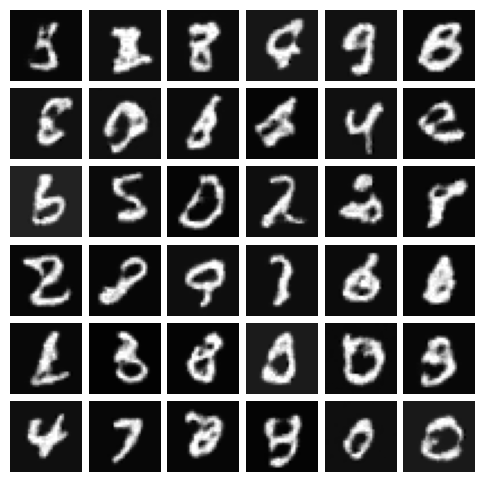

In [ ]:
plot_samples(glow, 36, device=DEVICE)

## CIFAR10

We applied the same architecture and hyperparameter settings to train another GLOW model on CIFAR10 dataset. The generated image is shown below.

In [ ]:
glow = GLOW(in_channels=3, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(glow.parameters(), lr=1e-3)
train(glow, optimizer,  cifar_train_loader, n_epochs=30, device=DEVICE, sample=True)

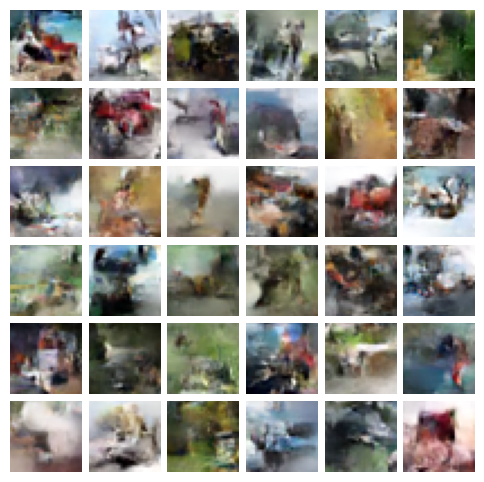

In [ ]:
plot_samples(glow, 36, device=DEVICE)